In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
from preprocessing.DateCategories import ultra_for_model
from PIL import Image
from torch.utils.data import Dataset, DataLoader

torch.cuda.empty_cache()
torch.manual_seed(19)
np.random.seed(19)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(19)

### Пути

In [2]:
root_image = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/photos/'
root_masks = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels/'
root_masks_rgb = 'C:/Users/tolik/information_technology/third_year/practice_project/CoreAnalysis-ML/data_for_study/labels_png/'

### Инструменты для работы

In [3]:
def visual_img_and_mask(photo_id, roots, photo_type='ultraviolet'):
    image = Image.open(roots[0] + '{}.jpeg'.format(photo_id))
    mask = Image.open(roots[1] + photo_type + '/label_{}.png'.format(photo_id))
    mask_npz = np.load(roots[2] + photo_type + '/label_{}.npz'.format(photo_id))
    image = np.asarray(image)
    mask = np.asarray(mask)
    image = cv2.resize(image, (512, 7680))
    mask = cv2.resize(mask, (512, 7680))
    mask_npz = mask_npz['x']
    mask_npz = cv2.resize(mask_npz, (512, 7680))
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 20))

    axes[0].imshow(image)
    axes[0].set_title('image')

    axes[1].imshow(mask)
    axes[1].set_title('mask')

    axes[2].imshow(mask_npz)
    axes[2].set_title('mask_npz')

    print('Size of Mask: {}\n'
          'Size of image: {}\n'
          'Size of Mask_npz: {}\n'
          .format(mask.shape, image.shape, mask_npz.shape))

### Гиперпараметры

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 3

### Предобработка фото в ультрофиолете

In [5]:
weight_array = []
height_array = []
for photo_id in ultra_for_model:
    img = cv2.imread(root_image + f'{photo_id}.jpeg')
    h, w, c = img.shape
    height_array.append(h)
    weight_array.append(w)

In [6]:
from scipy import stats
print('mode of h: ', stats.mode(height_array))
print('mode of w: ', stats.mode(weight_array))

mode of h:  ModeResult(mode=array([7823]), count=array([5]))
mode of w:  ModeResult(mode=array([677]), count=array([16]))


<BarContainer object of 760 artists>

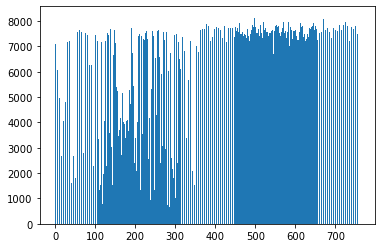

In [7]:
plt.bar(x = np.arange(len(height_array)), height=height_array)

<BarContainer object of 760 artists>

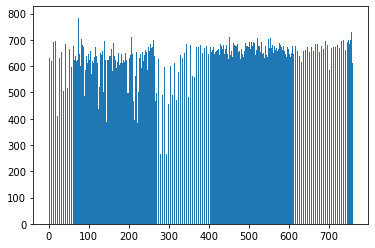

In [8]:
plt.bar(x = np.arange(len(weight_array)), height=weight_array)

Преимущественно все фотографии имеют размеры: height в диапвзоне от 7000 до 8000, weight в диапазоне от 600 до 700 (750)  
Оставим только те фотографии, у которых w и h принадлежат указанным диапазонам.

In [9]:
new_data_for_ultra = []
new_data_height = []
new_data_weight = []
for photo_id in ultra_for_model:
    img = cv2.imread(root_image + f'{photo_id}.jpeg')
    h, w, c = img.shape
    if (h >= 7000 and h <= 8000) and (w >= 600):
        new_data_for_ultra.append(photo_id)
        new_data_height.append(h)
        new_data_weight.append(w)
print(f'Длина новой выборки: {len(new_data_for_ultra)}')

Длина новой выборки: 469


<BarContainer object of 469 artists>

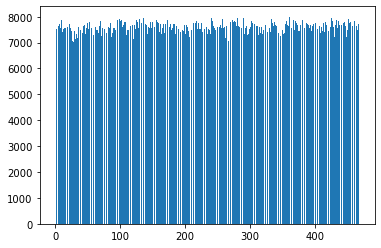

In [10]:
plt.bar(x = np.arange(len(new_data_height)), height = new_data_height)

<BarContainer object of 469 artists>

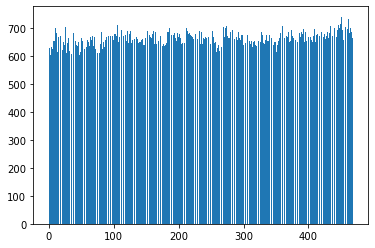

In [11]:
plt.bar(x = np.arange(len(new_data_weight)), height = new_data_weight)

In [12]:
print(f'Средняя высота - {np.mean(new_data_height)}, средняя ширина - {np.mean(new_data_weight)}')

Средняя высота - 7598.533049040511, средняя ширина - 664.0341151385927


In [13]:
np.mean(new_data_height) / np.mean(new_data_weight)

11.442985948778546

In [18]:
print(np.mean(new_data_height) // 256 * 256 / 8, np.mean(new_data_weight) // 256 * 256 / 4)

928.0 128.0


Будем приводить размеры к размерам 928 на 128

### Данные для обучения

In [16]:
# разобьем все изображения на тренировочную, тестовую, валидационную части
X_train, X_test = train_test_split(new_data_for_ultra, test_size = 0.2, random_state = 19)
X_train, X_val = train_test_split(X_train, test_size = 0.1, random_state = 19)

print('Размер X_train: {}\n'
      'Размер X_test: {}\n'
      'Размер X_val: {}'
      .format(len(X_train), len(X_test), len(X_val)))

Размер X_train: 337
Размер X_test: 94
Размер X_val: 38


Size of Mask: (7680, 512, 3)
Size of image: (7680, 512, 3)
Size of Mask_npz: (7680, 512)



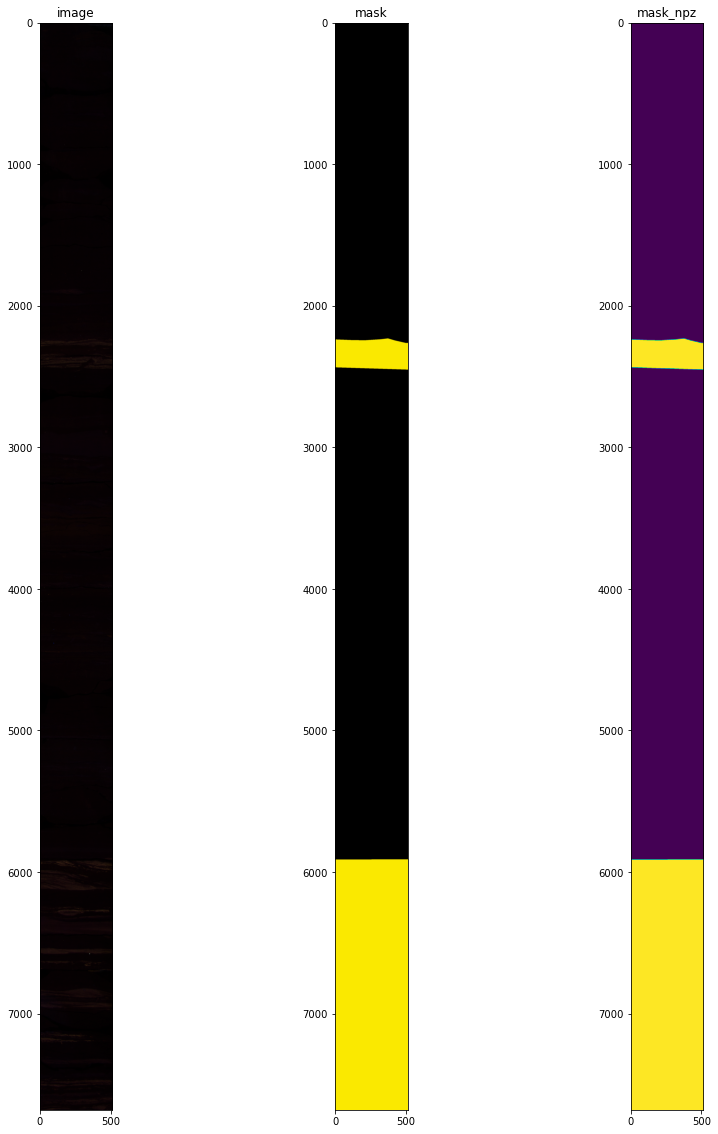

In [64]:
visual_img_and_mask(1006679, [root_image, root_masks_rgb, root_masks])

Определим итератор для наших данных, который сможет возвращать уже предобработанные(Resize + Convert to tensor) пары (изображение, маска)

In [25]:
class UltravioletDataset(Dataset):
    classes = ['Насыщенное', 'Отсутствует', 'Карбонатное']
    def __init__(self, image_path, mask_path, data,
                 mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.data = data # хранилище ID-шников
        self.transform = transform
        self.std = std
        self.mean = mean
    def __len__(self):
        # количество изображений в датасете
        return len(self.data)
    
    def __getitem__(self, idx):
        # возвращаем изображение с маской по индексу в data
        # загрузка
        img = Image.open(self.image_path + str(self.data[idx]) + '.jpeg')
        mask = np.load(self.mask_path + 'ultraviolet/label_' + str(self.data[idx]) + '.npz')['x']
        
        # аугментации (если есть)
        if self.transform is not None:
            augmentation = self.transform(image=img, mask=mask)
            img = Image.fromarray(augmentation['image'])
            mask = augmentation['mask']
        # обязательные преобразования
        t = T.Compose([
                T.Resize([928, 128]),
                T.ToTensor(),
                T.Normalize(self.mean, self.std)
            ])
        img = t(img)
        mask = cv2.resize(mask, (128, 928))
        mask = torch.from_numpy(mask).long()
        #print('we have: size of img: {}, size of mask: {}'.
         #    format(img.shape, mask.shape))
        
        return img, mask

#### Аугментации

In [26]:
import albumentations as A

In [27]:
# определим итераторы для тестового и валидационного датасетов
train_set = UltravioletDataset(image_path = root_image,
                               mask_path = root_masks,
                               data = X_train)
val_set = UltravioletDataset(image_path = root_image,
                               mask_path = root_masks,
                               data = X_val)
test_set = UltravioletDataset(image_path = root_image,
                               mask_path = root_masks,
                               data = X_test)

In [28]:
# Загрузчики данных
train_dataloader = DataLoader(dataset=train_set,
                              batch_size=1,
                              shuffle=True,
                              num_workers=0)
val_dataloader = DataLoader(dataset=val_set,
                            batch_size=1,
                            shuffle=True,
                            num_workers=0)
test_dataloader = DataLoader(dataset=test_set,
                            batch_size=1,
                            shuffle=True)

### Создание и обучение модели

In [41]:
import segmentation_models_pytorch as smp

classes = ['Насыщенное', 'Отсутствует', 'Карбонатное']
## encoder_depth - глубина encode-части. Если исходное изображение h * w,
## то в конце encode-слоя оно будет (h / 2**depth) * (w / 2**depth)

# Fully - convolution net
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=3, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

# чаще всего берут Adam с стандартным lr
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.01)
# т.к. с Dice могут быть проблемы из-за недифференцируемости,
# будем исп. Crossentropy как основную лосс-функцию и Dice как вспомогательную
loss = smp.utils.losses.CrossEntropyLoss()
loss_help = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

In [42]:
train_epoch = smp.utils.train.TrainEpoch(
        model = model, loss=loss,
        metrics = metrics, optimizer=optimizer,
        device=device, verbose=True)
val_epoch = smp.utils.train.ValidEpoch(
        model = model, loss=loss,
        metrics = metrics,
        device=device, verbose=True)

In [43]:
score = 0
for e in range(1, 31):
    print('Epoch: {} / 30'.format(e))
    train_res = train_epoch.run(train_dataloader)
    val_res = val_epoch.run(val_dataloader)
    if score < val_res['iou_score']:
        score = val_res['iou_score']
        print('new score = ', val_res['iou_score'])
        torch.save(model, './best_model_UNET_928x128.pth')
        print('Model was saved')

Epoch: 1 / 30
valid: 100%|██████████████████████████| 38/38 [00:17<00:00,  2.17it/s, cross_entropy_loss - 0.7914, iou_score - 0.5415]
new score =  0.5415324572673974
Model was saved
Epoch: 2 / 30
valid: 100%|██████████████████████████| 38/38 [00:16<00:00,  2.33it/s, cross_entropy_loss - 0.8554, iou_score - 0.1151]
Epoch: 3 / 30
valid: 100%|███████████████████████████| 38/38 [00:16<00:00,  2.24it/s, cross_entropy_loss - 0.7853, iou_score - 0.269]
Epoch: 4 / 30
valid: 100%|██████████████████████████| 38/38 [00:16<00:00,  2.36it/s, cross_entropy_loss - 0.6524, iou_score - 0.2848]
Epoch: 5 / 30
valid: 100%|██████████████████████████| 38/38 [00:17<00:00,  2.18it/s, cross_entropy_loss - 0.5638, iou_score - 0.4538]
Epoch: 6 / 30
valid: 100%|██████████████████████████| 38/38 [00:14<00:00,  2.71it/s, cross_entropy_loss - 0.5648, iou_score - 0.3865]
Epoch: 7 / 30
valid: 100%|██████████████████████████| 38/38 [00:13<00:00,  2.79it/s, cross_entropy_loss - 0.6617, iou_score - 0.3342]
Epoch: 8 / 30


KeyboardInterrupt: 

### Тестирование модели

In [44]:
best_model_UNET = torch.load('best_model_UNET_928x128.pth')

Оригинал

<class 'torch.Tensor'> <class 'torch.Tensor'> [0 1 2]
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


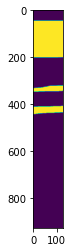

In [45]:
img, mask = test_set[19]
print(type(img), type(mask), np.unique(mask))
plt.imshow(mask)
print(mask)

In [46]:
pred_mask = best_model_UNET.predict(img.unsqueeze(0))

In [47]:
pred_mask = pred_mask.argmax(dim=1)
pred_mask = pred_mask.squeeze()
print(pred_mask.shape)

torch.Size([928, 128])


Предсказание

tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


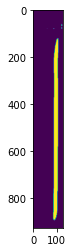

In [48]:
plt.imshow(pred_mask)
print(pred_mask)

In [118]:
np.unique(pred_mask)

array([0, 1, 2], dtype=int64)